# Talent Intelligence System ( Data Exploration)

This notebook serves as the primary analysis environment for **Step 1: Discover the Pattern of Success**.

**Objective:** The primary goal of this notebook is to perform a deep exploratory data analysis (EDA) to uncover the key attributes, competencies, and behavioral patterns that differentiate high-performing employees (those with a `rating = 5`) from their peers.

**Process:**
The analysis will follow these key steps:
1.  **Setup:** Import all necessary libraries and establish a connection to the Supabase database.
2.  **Data Loading:** Load all raw tables from the database into Pandas DataFrames.
3.  **Data Cleaning & Preprocessing:** Handle missing values, standardize inconsistent text data (like `mbti`), and create a master analysis DataFrame.
4.  **Exploratory Data Analysis (EDA):** Compare the "High Performer" group against all others across several key dimensions:
    * Psychometric & Cognitive (`iq`, `pauli`, `disc`, etc.)
    * Competencies (`competencies_yearly`)
    * Behavioral Strengths (`strengths`)
    * Contextual Factors (`grade_id`, `years_of_service_months`)
5.  **Synthesis:** Use visualizations and statistical summaries to identify the most significant factors.

**End Goal:** The insights gathered here will be synthesized into a **"Final Success Formula"**. This formula will provide the logical foundation for the SQL matching algorithm to be built in Step 2.

## Setup Preparation

In [61]:
# Install neccessary ilbraries
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# Load the secret credentials from  .env file

load_dotenv()

DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')

print("Environment variables loaded.")


Environment variables loaded.


In [63]:
# Create the connection 'engine' to  Supabase database

connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

print("Database connection engine created successfully.")

Database connection engine created successfully.


In [64]:
# Overview of certain tables for intial checking
df_employees = pd.read_sql(
  
  """
  SELECT 
  * 
  FROM employees
  """

  , engine)
print("\n--- Employee Data Info ---")
display(df_employees.info(), df_employees.head())


--- Employee Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   employee_id              2010 non-null   object
 1   fullname                 2010 non-null   object
 2   nip                      2010 non-null   object
 3   company_id               2010 non-null   int64 
 4   area_id                  2010 non-null   int64 
 5   position_id              2010 non-null   int64 
 6   department_id            2010 non-null   int64 
 7   division_id              2010 non-null   int64 
 8   directorate_id           2010 non-null   int64 
 9   grade_id                 2010 non-null   int64 
 10  education_id             2010 non-null   int64 
 11  major_id                 2010 non-null   int64 
 12  years_of_service_months  2010 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 204.3+ KB


None

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,3,1,64
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,1,2,16
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,3,1,58
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,2,5,15
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,1,5,34


## Data Load and Preparation

To optimize performance and avoid excessive load on the database (as per quota concerns),  hybrid loading strategy is being used:

1.  **Main Query (`df_main`):** A single SQL query will join all **one-to-one** tables (`employees`, `profiles_psych`) and the latest performance record (`performance_yearly` filtered for 2025). This creates our primary, unique-per-employee analysis table.
2.  **Separate Queries:** All **one-to-many** tables (`competencies_yearly`, `strengths`) will be loaded separately. They will be merged in Python *only when needed* for a specific analysis to prevent row explosion.

### Load for One to One Data

In [65]:
#  Load Main One to One Data
df_main= pd.read_sql(
  
  """
  SELECT
    e.*,
    pp.pauli,
    pp.faxtor,
    pp.disc,
    pp.disc_word,
    pp.mbti,
    pp.iq,
    pp.gtq,
    pp.tiki,
    py.rating,
    py.year as current_year
  FROM employees as e
  LEFT JOIN  profiles_psych as pp
  ON e.employee_id = pp.employee_id 
  LEFT JOIN   
  (SELECT * 
  FROM performance_yearly 
  WHERE year = 2025) 
  as py
  ON e.employee_id = py.employee_id

  """
  , engine)
print("\n--- Main Data Info ---")
display(df_main.info(), df_main.head())

print(f"Main analysis table loaded successfully with {len(df_main)} unique employees.")


--- Main Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              2010 non-null   object 
 1   fullname                 2010 non-null   object 
 2   nip                      2010 non-null   object 
 3   company_id               2010 non-null   int64  
 4   area_id                  2010 non-null   int64  
 5   position_id              2010 non-null   int64  
 6   department_id            2010 non-null   int64  
 7   division_id              2010 non-null   int64  
 8   directorate_id           2010 non-null   int64  
 9   grade_id                 2010 non-null   int64  
 10  education_id             2010 non-null   int64  
 11  major_id                 2010 non-null   int64  
 12  years_of_service_months  2010 non-null   int64  
 13  pauli                    2010 non-null   int64  
 14  

None

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3,3.0,2025
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,66,38,DC,Dominant-Conscientious,None,109.0,20.0,3,4.0,2025
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,3.0,2025
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,75,100,None,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025


Main analysis table loaded successfully with 2010 unique employees.


### Load One to Many Data Seperately

In [66]:
# Competencies table
df_competencies= pd.read_sql(
  
  """
  SELECT
    cy.employee_id,
    cy.pillar_code,
    dc.pillar_label,
    cy.score,
    cy.year
  FROM competencies_yearly as cy
  LEFT JOIN dim_competency_pillars as dc
  ON cy.pillar_code = dc.pillar_code
  WHERE 
  cy.year = 2025
  """
  , engine)
print("\n--- Competencies Info ---")
display(df_competencies.info(), df_competencies.head())
print(f"Competency data loaded with {len(df_competencies)} rows.")


--- Competencies Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   20100 non-null  object 
 1   pillar_code   20100 non-null  object 
 2   pillar_label  20100 non-null  object 
 3   score         18495 non-null  float64
 4   year          20100 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 785.3+ KB


None

,employee_id,pillar_code,pillar_label,score,year
0,EMP100000,GDR,Growth Drive & Resilience,3.0,2025
1,EMP100001,GDR,Growth Drive & Resilience,2.0,2025
2,EMP100002,GDR,Growth Drive & Resilience,3.0,2025
3,EMP100003,GDR,Growth Drive & Resilience,4.0,2025
4,EMP100004,GDR,Growth Drive & Resilience,4.0,2025


Competency data loaded with 20100 rows.


In [67]:
# Strengths table
df_strengths= pd.read_sql(
  
  """
  SELECT
    employee_id,
    rank,
    theme
  FROM strengths
  ORDER BY 1 ASC, 2 ASC

  """
  , engine)
print("\n--- Strengths Info ---")
display(df_strengths.info(), df_strengths.head())
print(f"Strengths data loaded with {len(df_strengths)} rows.")


--- Strengths Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28140 entries, 0 to 28139
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  28140 non-null  object
 1   rank         28140 non-null  int64 
 2   theme        28140 non-null  object
dtypes: int64(1), object(2)
memory usage: 659.7+ KB


None

,employee_id,rank,theme
0,DUP1942,1,Learner
1,DUP1942,2,Maximizer
2,DUP1942,3,Ideation
3,DUP1942,4,Harmony
4,DUP1942,5,Restorative


Strengths data loaded with 28140 rows.


In [68]:
# Papi_scores table
df_papi_scores= pd.read_sql(
  
  """
  SELECT
    employee_id,
    scale_code,
    score
  FROM papi_scores
  ORDER BY 1 ASC, 2 ASC
  """
  , engine)
print("\n--- PAPI Scores Info ---")
display(df_papi_scores.info(), df_papi_scores.head())
print(f"PAPI Scores data loaded with {len(df_papi_scores)} rows.")


--- PAPI Scores Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  40200 non-null  object 
 1   scale_code   40200 non-null  object 
 2   score        36997 non-null  float64
dtypes: float64(1), object(2)
memory usage: 942.3+ KB


None

,employee_id,scale_code,score
0,DUP1942,Papi_A,6.0
1,DUP1942,Papi_B,NaN
2,DUP1942,Papi_C,1.0
3,DUP1942,Papi_D,4.0
4,DUP1942,Papi_E,3.0


PAPI Scores data loaded with 40200 rows.


In [69]:
df_main[df_main['disc'].isnull()]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,75,100,None,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025
22,EMP100022,Oka Nugroho,674733,2,1,2,3,1,2,2,...,49,94,None,Influencer-Conscientious,ISTP,91.0,35.0,8,4.0,2025
37,EMP100037,Nabila Ramadhan,967856,1,1,6,4,2,1,2,...,45,41,None,Conscientious-Influencer,ISTJ,NaN,NaN,1,4.0,2025
46,EMP100046,Fitri Lestari,117913,3,4,1,4,3,1,2,...,67,91,None,Dominant-Conscientious,ISTJ,NaN,NaN,6,2.0,2025
62,EMP100062,Valdo Jatmiko Mahendra,249908,3,3,4,6,3,2,2,...,42,25,None,Dominant-Influencer,ISTP,89.0,31.0,8,3.0,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,EMP101912,Umar Ramadhan,583501,4,2,4,4,1,3,1,...,97,73,None,Influencer-Dominant,INFJ,NaN,NaN,6,4.0,2025
1946,EMP101946,Putri Maulida,108026,1,2,5,4,3,2,3,...,55,20,None,Conscientious-Steadiness,ISFP,NaN,NaN,6,3.0,2025
1952,EMP101952,Bayu Setiawan,712745,1,3,2,3,5,3,2,...,44,35,None,Dominant-Conscientious,INTJ,116.0,17.0,3,3.0,2025
1962,EMP101962,Rani Yudhistira Anggara,521850,1,3,2,3,3,2,2,...,23,96,None,Influencer-Dominant,ENTP,99.0,30.0,9,2.0,2025


In [71]:
df_main[df_main['mbti'].isnull()]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,66,38,DC,Dominant-Conscientious,None,109.0,20.0,3,4.0,2025
5,EMP100005,Bayu Zulfikar,590302,1,1,5,2,3,1,1,...,69,35,DC,Dominant-Conscientious,None,130.0,21.0,7,3.0,2025
35,EMP100035,Oka Tamba,243414,3,4,1,5,4,3,3,...,84,36,DI,Dominant-Influencer,None,103.0,28.0,7,2.0,2025
50,EMP100050,Joko Ridwan,411437,4,3,4,3,5,3,1,...,81,54,DC,Dominant-Conscientious,None,131.0,32.0,6,5.0,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,EMP101981,Novi Aji Suharto,812259,3,2,6,4,3,1,1,...,70,48,IS,Influencer-Steadiness,None,NaN,NaN,5,4.0,2025
1985,EMP101985,Dwi Kusuma,463869,2,4,2,6,5,1,1,...,43,62,None,Influencer-Conscientious,None,98.0,16.0,7,2.0,2025
1989,EMP101989,Gita Tri Gunawan,897663,4,1,4,5,1,1,1,...,76,34,DS,Dominant-Steadiness,None,91.0,18.0,4,3.0,2025
1992,EMP101992,Maya Anugrah Hasibuan,505313,2,4,6,5,5,2,1,...,49,67,IC,Influencer-Conscientious,None,110.0,30.0,5,NaN,2025


## Data Cleaning and Manipulation

### Oe to One Main data

#### Duplicate Check

In [72]:
# Check the duplicate value in employee_id as the primary key
df_main[df_main['employee_id'].duplicated()]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year


There is no duplicate value in employee_id 

#### Check null value

In [97]:
df_main.isnull().sum()

employee_id                  0
fullname                     0
nip                          0
company_id                   0
area_id                      0
position_id                  0
department_id                0
division_id                  0
directorate_id               0
grade_id                     0
education_id                 0
major_id                     0
years_of_service_months      0
pauli                        0
faxtor                       0
disc                       171
disc_word                    0
mbti                       149
iq                         456
gtq                        332
tiki                         0
rating                     216
current_year                 0
dtype: int64

There are :
* **`disc`**: 171 missing values
* **`mbti`**: 149 missing values
* **`iq`**: 456 missing values
* **`gtq`**: 332 missing values 
* **`rating`**: 216 missing values

**Action Plan:**

First Step (Source from the main data) :

1.  **`rating`:** Rows with missing `rating` will be **dropped**. This value is essential for defining our target variable (`is_high_performer`) and cannot be reliably imputed.

In [98]:
print("--- Handling Missing Values ---")

# Make a copy for cleaning process the null values
df_main_null= df_main.copy()

# Action 1: Drop rows where 'rating' is missing
rows_before = len(df_main_null)
df_main_null.dropna(subset=['rating'], inplace=True)
rows_after = len(df_main_null)
print(f"Dropped {rows_before - rows_after} rows due to missing 'rating'.")

--- Handling Missing Values ---
Dropped 216 rows due to missing 'rating'.


**Data Distribution Check to determined the imputed value method:**

(Source from data that null rating already being dropped)

**`iq` (456), `gtq` (332), `mbti` (149), `disc` (171) (Significant Missingness):** Simply dropping rows with missing values for these columns would lead to a substantial loss of data (potentially over 456 rows just for `iq`), which could significantly skew the analysis or reduce the statistical power of our findings. Therefore, **imputation is the preferred strategy** despite its potential biases.

1.  **Numerical (`iq`, `gtq`):** check for skewness and outliers using histograms and boxplots. This helps determine if the median (robust to outliers/skew) or mean is more appropriate.

2.  **Categorical (`mbti`, `disc`):** check the frequency distribution using `value_counts()`. This helps determine if the mode is a reasonable representation or if it will overly dominate the data after imputation.

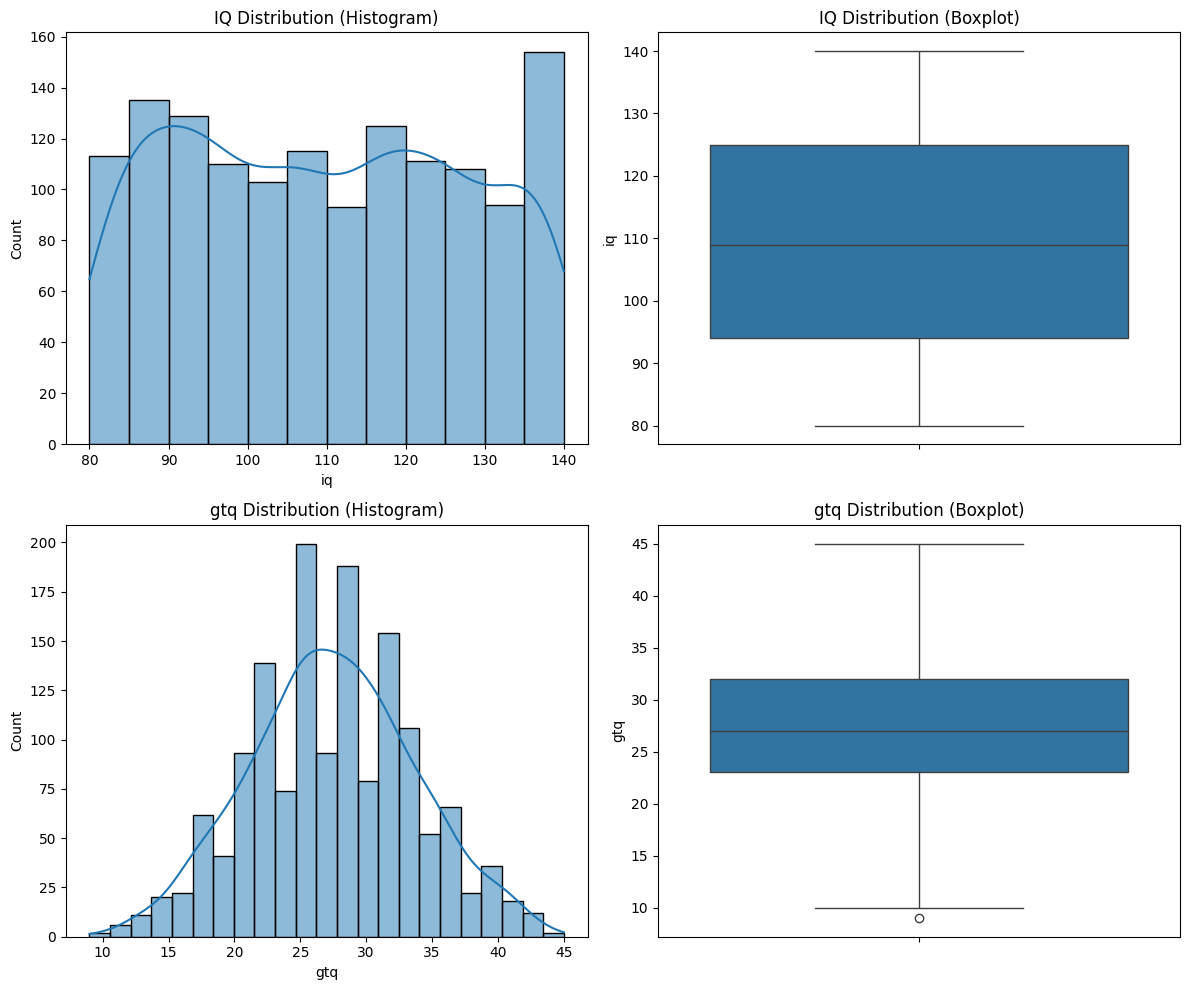

In [99]:
#  Check Distribution of 'iq' and 'gtq_total'

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # Adjust figsize as needed

# --- IQ Plots (Top Row) ---

# Top-left: Histogram for IQ
sns.histplot(df_main_null['iq'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('IQ Distribution (Histogram)')

# Top-right: Boxplot for IQ
sns.boxplot(y=df_main_null['iq'], ax=axes[0, 1])
axes[0, 1].set_title('IQ Distribution (Boxplot)')

# --- GTQ Total Plots (Bottom Row) ---
gtq_col_name = 'gtq' # 

if gtq_col_name in df_main_null.columns:
    # Bottom-left: Histogram for GTQ Total
    sns.histplot(df_main_null[gtq_col_name], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'{gtq_col_name} Distribution (Histogram)')

    # Bottom-right: Boxplot for GTQ Total
    sns.boxplot(y=df_main_null[gtq_col_name], ax=axes[1, 1])
    axes[1, 1].set_title(f'{gtq_col_name} Distribution (Boxplot)')
else:
    print(f"Warning: Column '{gtq_col_name}' not found in df_main. Skipping GTQ plots.")
    # Optionally hide the bottom row if the column doesn't exist
    axes[1, 0].set_visible(False)
    axes[1, 1].set_visible(False)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()


In [100]:
#  Check Distribution of Categorical Data ('mbti' and 'disc') 

print("--- MBTI Value Distribution (Normalized) ---")
# Using normalize=True gives percentage, easier to judge dominance
# .head(10) shows the top 10 most frequent types
print(df_main_null['mbti'].value_counts(normalize=True).head(10))

print("\n--- DISC Value Distribution (Normalized) ---")
# Check distribution for DISC as well
print(df_main_null['disc'].value_counts(normalize=True).head(10))

--- MBTI Value Distribution (Normalized) ---
mbti
ENFP    0.079422
ENFJ    0.070397
INTP    0.068592
INFP    0.064982
ENTP    0.063779
ESFJ    0.063177
ENTJ    0.061974
ISFP    0.061974
ISTP    0.061974
ISTJ    0.059567
Name: proportion, dtype: float64

--- DISC Value Distribution (Normalized) ---
disc
CI    0.094570
CD    0.093960
DC    0.092129
SC    0.090299
SI    0.089689
CS    0.084808
DI    0.081757
ID    0.077486
IC    0.076266
DS    0.075046
Name: proportion, dtype: float64


In [101]:
pd.pivot_table(df_main, index='disc_word', columns='disc', aggfunc='size', fill_value=0)

disc,CD,CI,CS,DC,DI,DS,IC,ID,IS,SC,SD,SI
disc_word,,,,,,,,,,,,
Conscientious-Dominant,169,0,0,0,0,0,0,0,0,0,0,0
Conscientious-Influencer,0,173,0,0,0,0,0,0,0,0,0,0
Conscientious-Steadiness,0,0,159,0,0,0,0,0,0,0,0,0
Dominant-Conscientious,0,0,0,163,0,0,0,0,0,0,0,0
Dominant-Influencer,0,0,0,0,154,0,0,0,0,0,0,0
Dominant-Steadiness,0,0,0,0,0,140,0,0,0,0,0,0
Influencer-Conscientious,0,0,0,0,0,0,147,0,0,0,0,0
Influencer-Dominant,0,0,0,0,0,0,0,143,0,0,0,0
Influencer-Steadiness,0,0,0,0,0,0,0,0,127,0,0,0



After checking the mode distribution for `mbti` and `disc`, and particularly confirming the consistent relationship between `disc_word` and `disc`, the following imputation strategy will be applied to handle missing values:

1.  **`disc` (171 missing):**
    * Missing `disc` values will first be imputed **using the corresponding `disc_word`** via a predefined mapping (e.g., 'Steadiness-Conscientious' maps to 'SC'). This leverages existing information for higher accuracy.
    * Any remaining missing `disc` values (where `disc_word` might also be missing or unmappable) will then be imputed using the **mode** (`CI`), as the overall distribution was found to be relatively even.

2.  **`mbti` (149 missing):**
    * Since no similar direct mapping is available and the distribution check showed no single type overly dominating (mode `ENFP` at ~8%), missing `mbti` values will be imputed using the **mode (`ENFP`)**.

*Potential Bias:* While these imputation methods help retain data rows, mode imputation can slightly inflate the frequency of the most common categories, and the mapping for `disc` relies on the completeness of `disc_word`. Results should be interpreted with this in mind.*

In [102]:
# Standardize DISC first
df_main_null['disc'] = df_main_null['disc'].str.upper().str.strip()
# Standardize disc_word as well (important for mapping)
df_main_null['disc_word'] = df_main_null['disc_word'].str.strip()
print("DISC standardized to uppercase and stripped.")

# Smart Imputation for DISC using disc_word
disc_map = {
    'Dominance-Influence': 'DI', 'Dominance-Steadiness': 'DS', 'Dominance-Conscientious': 'DC',
    'Influence-Dominance': 'ID', 'Influence-Steadiness': 'IS', 'Influence-Conscientious': 'IC',
    'Steadiness-Dominance': 'SD', 'Steadiness-Influence': 'SI', 'Steadiness-Conscientious': 'SC',
    'Conscientious-Dominance': 'CD', 'Conscientious-Influence': 'CI', 'Conscientious-Steadiness': 'CS',
    'Dominance': 'D', 'Influence': 'I', 'Steadiness': 'S', 'Conscientious': 'C'
    # Add any other observed variations from df_main['disc_word'].unique()
}
print(f"\nMissing 'disc' values (Before smart impute): {df_main_null['disc'].isnull().sum()}")
mapped_disc = df_main_null['disc_word'].map(disc_map)
df_main_null['disc'].fillna(mapped_disc, inplace=True) # Use inplace=False if you encounter warnings
print(f"Missing 'disc' values (After mapping): {df_main_null['disc'].isnull().sum()}")

# Impute any remaining missing DISC with mode (if disc_word was also missing/unmappable)
if df_main_null['disc'].isnull().sum() > 0:
    print("Some 'disc' values still missing, imputing remaining with mode.")
    mode_disc = df_main_null['disc'].mode()[0]
    df_main_null['disc'].fillna(mode_disc, inplace=True) # Use inplace=False if you encounter warnings

# --- 3.4 Verification ---
print("\n--- Missing Values in df_main (After Cleaning) ---")
print(df_main_null.isnull().sum())

DISC standardized to uppercase and stripped.

Missing 'disc' values (Before smart impute): 155
Missing 'disc' values (After mapping): 130
Some 'disc' values still missing, imputing remaining with mode.

--- Missing Values in df_main (After Cleaning) ---
employee_id                  0
fullname                     0
nip                          0
company_id                   0
area_id                      0
position_id                  0
department_id                0
division_id                  0
directorate_id               0
grade_id                     0
education_id                 0
major_id                     0
years_of_service_months      0
pauli                        0
faxtor                       0
disc                         0
disc_word                    0
mbti                       132
iq                         404
gtq                        297
tiki                         0
rating                       0
current_year                 0
dtype: int64


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_20124\661218260.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_main_null['disc'].fillna(mapped_disc, inplace=True) # Use inplace=False if you encounter warnings


Second Step (Source from data that null rating already being dropped):

Therefore: 
2.  **`iq` & `gtq` (Numerical):** Given the presence of outliers, imputation using the **median** is confirmed as the most robust choice to avoid skewing the central tendency.

    * *Potential Bias:* Imputing with the median may slightly reduce the variance of these scores.

3.  **`mbti` & `disc` (Categorical):** Since the distributions are relatively even, imputation using the **mode** (`ENFP` for `mbti`, `CI` for `disc`) is deemed acceptable.

    * *Potential Bias:* This will slightly increase the frequency of the modal categories, but the effect is expected to be minimal due to the original spread.

*The analysis results should be interpreted with these potential imputation biases in mind.*

In [103]:
#Imputation value

# Verify initial missing counts
print("\n--- Missing Values (Before Imputation) ---")
print(df_main_null[['iq', 'gtq', 'mbti']].isnull().sum())

# Action 1: Impute numerical columns ('iq', 'gtq_total') with median
median_iq = df_main_null['iq'].median()
df_main_null['iq']=df_main_null['iq'].fillna(median_iq)
print(f"\nMissing 'iq' imputed with median: {median_iq}")

# Assuming 'gtq_total' is the correct column name
median_gtq = df_main_null['gtq'].median()
df_main_null['gtq']=df_main_null['gtq'].fillna(median_gtq)
print(f"Missing 'gtq' imputed with median: {median_gtq}")

# Action 2: Impute categorical columns ('mbti) with mode
mode_mbti = df_main_null['mbti'].mode()[0] # .mode() can return multiple values if ties exist, [0] selects the first one
df_main_null['mbti'].fillna(mode_mbti, inplace=True)
print(f"Missing 'mbti' imputed with mode: '{mode_mbti}'")


# --- Verification ---
print("\n--- Missing Values (After Imputation) ---")
# Check only the imputed columns
print(df_main_null[['iq', 'gtq', 'mbti']].isnull().sum())


--- Missing Values (Before Imputation) ---
iq      404
gtq     297
mbti    132
dtype: int64

Missing 'iq' imputed with median: 109.0
Missing 'gtq' imputed with median: 27.0
Missing 'mbti' imputed with mode: 'ENFP'

--- Missing Values (After Imputation) ---
iq      0
gtq     0
mbti    0
dtype: int64


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_20124\1070603626.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_main_null['mbti'].fillna(mode_mbti, inplace=True)


In [104]:
display(df_main_null.isnull().sum(), len(df_main_null))

employee_id                0
fullname                   0
nip                        0
company_id                 0
area_id                    0
position_id                0
department_id              0
division_id                0
directorate_id             0
grade_id                   0
education_id               0
major_id                   0
years_of_service_months    0
pauli                      0
faxtor                     0
disc                       0
disc_word                  0
mbti                       0
iq                         0
gtq                        0
tiki                       0
rating                     0
current_year               0
dtype: int64

1794

Final data after cleaning the missing/null values is 1794

#### Irrelevant value/ Typo in Categorical column

In [91]:
df_main_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 0 to 2009
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              1794 non-null   object 
 1   fullname                 1794 non-null   object 
 2   nip                      1794 non-null   object 
 3   company_id               1794 non-null   int64  
 4   area_id                  1794 non-null   int64  
 5   position_id              1794 non-null   int64  
 6   department_id            1794 non-null   int64  
 7   division_id              1794 non-null   int64  
 8   directorate_id           1794 non-null   int64  
 9   grade_id                 1794 non-null   int64  
 10  education_id             1794 non-null   int64  
 11  major_id                 1794 non-null   int64  
 12  years_of_service_months  1794 non-null   int64  
 13  pauli                    1794 non-null   int64  
 14  faxtor                   1794

In [90]:
df_main[df_main['disc'].isnull()]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,75,100,None,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025
22,EMP100022,Oka Nugroho,674733,2,1,2,3,1,2,2,...,49,94,None,Influencer-Conscientious,ISTP,91.0,35.0,8,4.0,2025
37,EMP100037,Nabila Ramadhan,967856,1,1,6,4,2,1,2,...,45,41,None,Conscientious-Influencer,ISTJ,NaN,NaN,1,4.0,2025
46,EMP100046,Fitri Lestari,117913,3,4,1,4,3,1,2,...,67,91,None,Dominant-Conscientious,ISTJ,NaN,NaN,6,2.0,2025
62,EMP100062,Valdo Jatmiko Mahendra,249908,3,3,4,6,3,2,2,...,42,25,None,Dominant-Influencer,ISTP,89.0,31.0,8,3.0,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,EMP101912,Umar Ramadhan,583501,4,2,4,4,1,3,1,...,97,73,None,Influencer-Dominant,INFJ,NaN,NaN,6,4.0,2025
1946,EMP101946,Putri Maulida,108026,1,2,5,4,3,2,3,...,55,20,None,Conscientious-Steadiness,ISFP,NaN,NaN,6,3.0,2025
1952,EMP101952,Bayu Setiawan,712745,1,3,2,3,5,3,2,...,44,35,None,Dominant-Conscientious,INTJ,116.0,17.0,3,3.0,2025
1962,EMP101962,Rani Yudhistira Anggara,521850,1,3,2,3,3,2,2,...,23,96,None,Influencer-Dominant,ENTP,99.0,30.0,9,2.0,2025


In [105]:
df_main_null.iloc[[4]]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,75,100,SC,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025


In [89]:
# Make a copy for irrelevant value check
df_main_irrelevant = df_main_null.copy()

# Check the value of each categorical columns 
